# IMPORT SEMUA LIBARY YANG DIBUTUHKAN

In [1]:
!pip install xgboost
!pip install lightgbm

In [2]:
# Import semua library yang dibutuhkan
#Untuk Data
import numpy as np
import pandas as pd


#untuk Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns


#Untuk kebutuhan proyek machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from yellowbrick.cluster import KElbowVisualizer
from sklearn.linear_model import  Ridge
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier


# Untuk Model Rekomendasi
from sklearn.neighbors import KNeighborsRegressor
#Untuk ekspor data dan penyimpanan model
import joblib


LOAD DATA

In [3]:
#Loading data dan Menampilkan data pada 5 baris pertama
df = pd.read_csv("Dataset_pertanian_dengan_pupuk.csv")
df.head()

,Province,District,Year,Commodity,Rain_mm,Temp_C,Humidity_pct,Soil_pH,Soil_N_index,Soil_P_index,...,Prev_Yield_KgHa,Production_KgHa,InputPrice_Urea_RpKg,InputPrice_SP36_RpKg,InputPrice_KCl_RpKg,Init_Capital_RpHa,Maintenance_Cost_RpHa,Pupuk_Urea_kgHa,Pupuk_SP36_kgHa,Pupuk_KCl_kgHa
0,Papua Barat Daya,Sorong Selatan,2020,Tebu,2248.4,26.6,85.4,4.25,3,1,...,69313.8,64746.9,7373,8304,12439,7514080,9517829,238.2,131.6,88.6
1,Sulawesi Utara,Manado,2023,Tebu,2118.8,28.2,74.7,4.80,2,1,...,59262.5,59313.4,7607,8503,11352,6923743,10322411,257.2,86.1,86.1
2,Gorontalo,Bone Bolango,2023,Padi,2561.7,26.2,90.0,5.01,3,2,...,6193.6,5279.4,7119,7209,12417,4106027,5578082,289.4,95.7,75.4
3,Sulawesi Barat,Mamasa,2019,Cabai Rawit,1956.5,28.4,75.7,5.68,1,2,...,10751.6,9704.8,5893,8685,11806,6117664,10014848,237.5,111.4,70.2
4,Kalimantan Timur,Paser,2024,Tebu,2600.9,28.5,78.1,5.12,3,3,...,71487.9,72259.5,6122,9587,9650,5721647,10051852,292.2,124.7,78.9


In [4]:
# Menampilkan jumlah baris kolom dan jenis data dalam dataset dengan info.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Province               50000 non-null  object 
 1   District               50000 non-null  object 
 2   Year                   50000 non-null  int64  
 3   Commodity              50000 non-null  object 
 4   Rain_mm                50000 non-null  float64
 5   Temp_C                 50000 non-null  float64
 6   Humidity_pct           50000 non-null  float64
 7   Soil_pH                50000 non-null  float64
 8   Soil_N_index           50000 non-null  int64  
 9   Soil_P_index           50000 non-null  int64  
 10  Soil_K_index           50000 non-null  int64  
 11  Area_Ha                50000 non-null  float64
 12  Prev_Yield_KgHa        50000 non-null  float64
 13  Production_KgHa        50000 non-null  float64
 14  InputPrice_Urea_RpKg   50000 non-null  int64  
 15  In

In [5]:
# Mengecek dataset menggunakan isnull().sum()
missing_values = df.isnull().sum()
missing_values [missing_values > 0]

,0


In [6]:
# Mengecek dataset menggunakan duplicated().sum()
jumlah_duplikat = df.duplicated().sum()
print("Jumlah data duplikat:", jumlah_duplikat)

Jumlah data duplikat: 0


# Data Cleaning

In [7]:
# Bersihkan nama kategori
for c in ["Province","District","Commodity"]:
    df[c] = df[c].astype(str).str.strip().str.title()

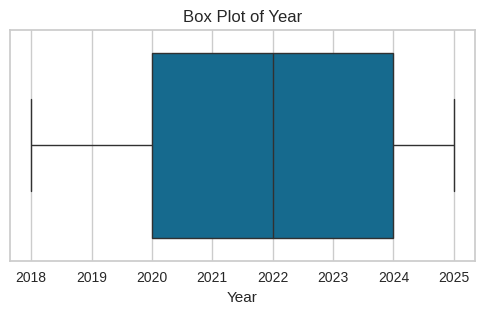

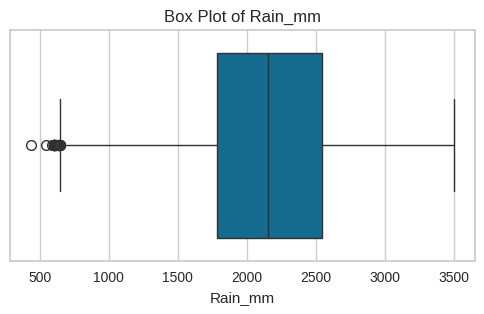

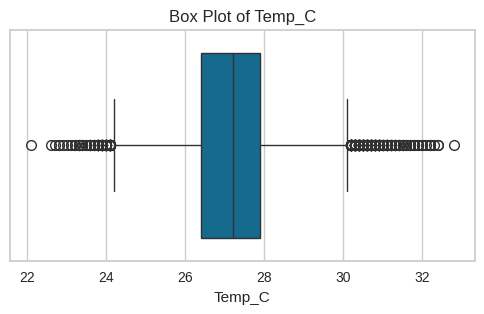

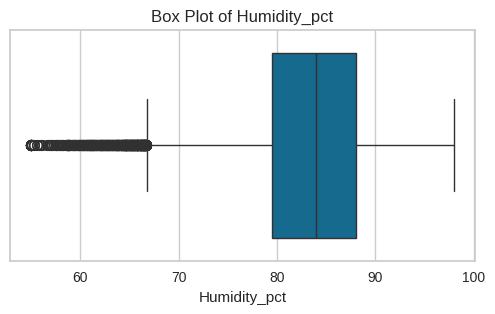

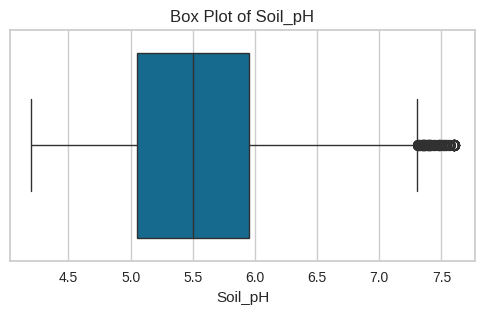

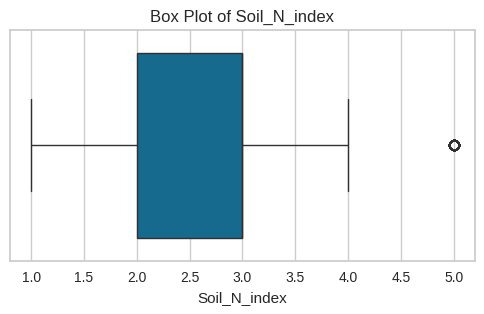

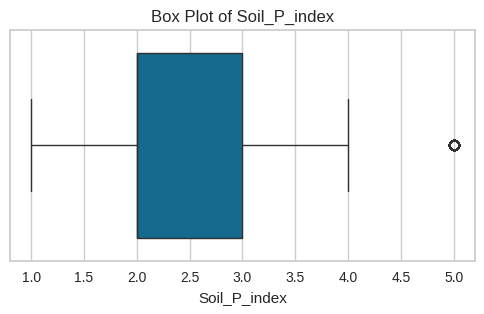

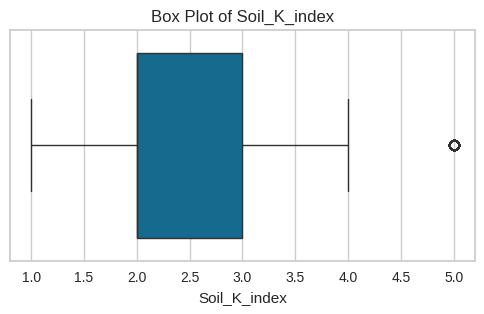

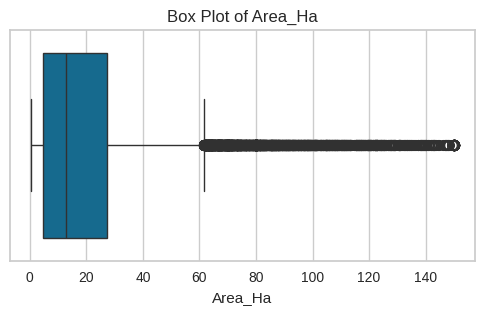

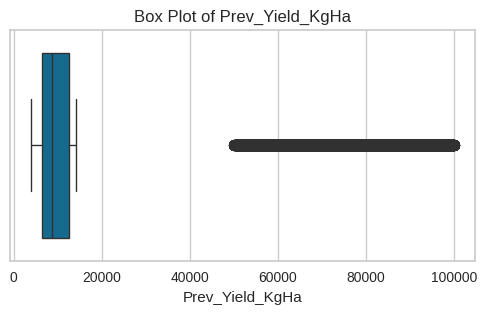

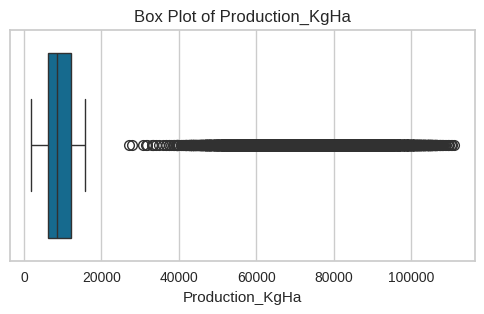

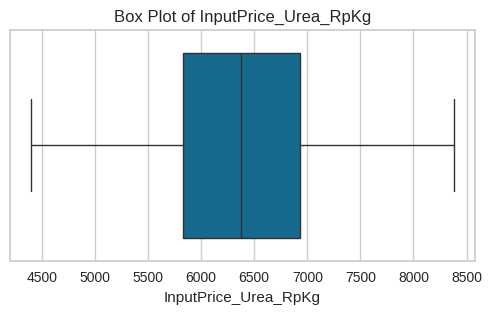

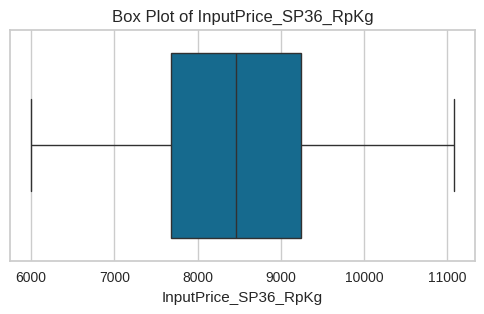

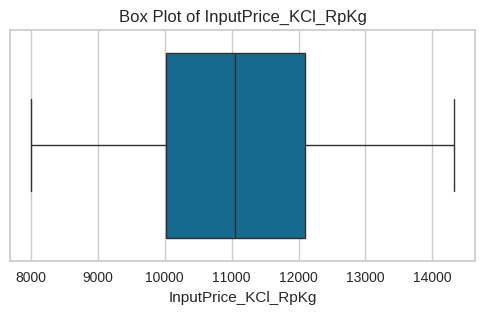

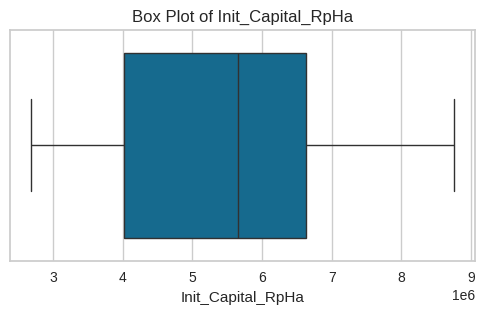

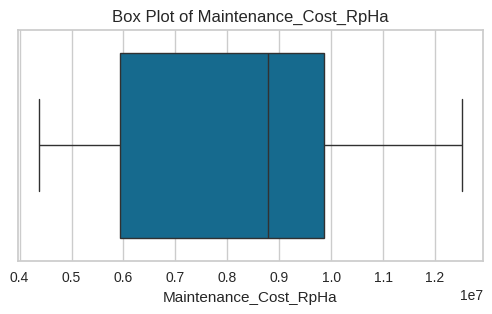

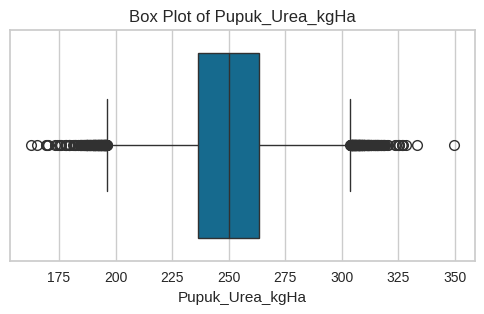

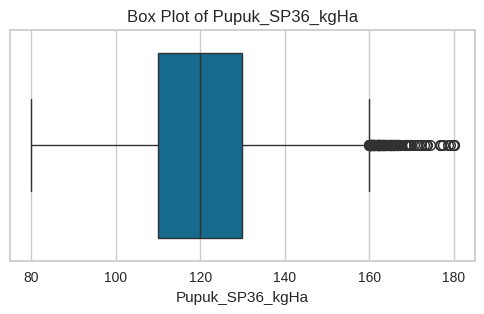

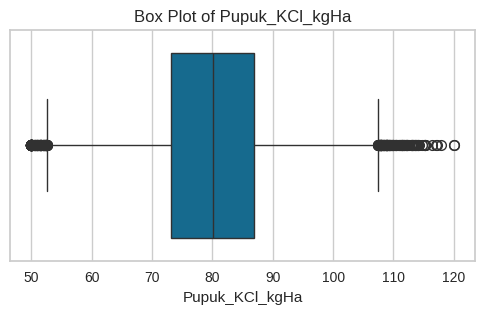

In [8]:

numeric_features = df.select_dtypes(include='number').columns
# Boxplot sebelum scaling
for feature in numeric_features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()


In [9]:
#Penanganan Outliers
# membersihkan kategori supaya konsisten
df["Commodity"] = df["Commodity"].astype(str).str.strip().str.title() #untuk kmoditas karena jika melakukan penghapusan outliers pada umumnya, terdapat komoditas yang hilang

# mengambil kolom numerik
numeric_features = df.select_dtypes(include=['float64','int64']).columns

# membuat dataframe kosong untuk menampung hasil
df_clean = pd.DataFrame()

# Loop untuk setiap komoditas
for komoditas, subset in df.groupby("Commodity"):
    # Hitung IQR untuk subset (komoditas tertentu)
    Q1 = subset[numeric_features].quantile(0.25)
    Q3 = subset[numeric_features].quantile(0.75)
    IQR = Q3 - Q1

    mask = ~((subset[numeric_features] < (Q1 - 3 * IQR)) |
             (subset[numeric_features] > (Q3 + 3 * IQR))).any(axis=1)


    df_clean = pd.concat([df_clean, subset[mask]])


In [10]:
#Pada pengujian deployment ke aplikasi ada beberapa data leakage

drop_cols_leakage = [
    "Prev_Yield_KgHa","Target_Yield_KgHa",
    "Yield_per_Area","Cost_per_Kg","Production_Trend",
    "Soil_pH_Category","Rain_Category"
]
# target dari model lain
drop_cols_other_targets = ["Pupuk_Urea_kgHa", "Pupuk_SP36_kgHa", "Pupuk_KCl_kgHa"]

# mendefinisikan target prediksi Anda
target_cols = ["Production_KgHa","Init_Capital_RpHa","Maintenance_Cost_RpHa"]

# Buat X dan y dari df_clean
all_cols_to_drop = drop_cols_leakage + drop_cols_other_targets + target_cols
X = df_clean.drop(columns=[col for col in all_cols_to_drop if col in df_clean.columns])
y = df_clean[target_cols]

# EDA

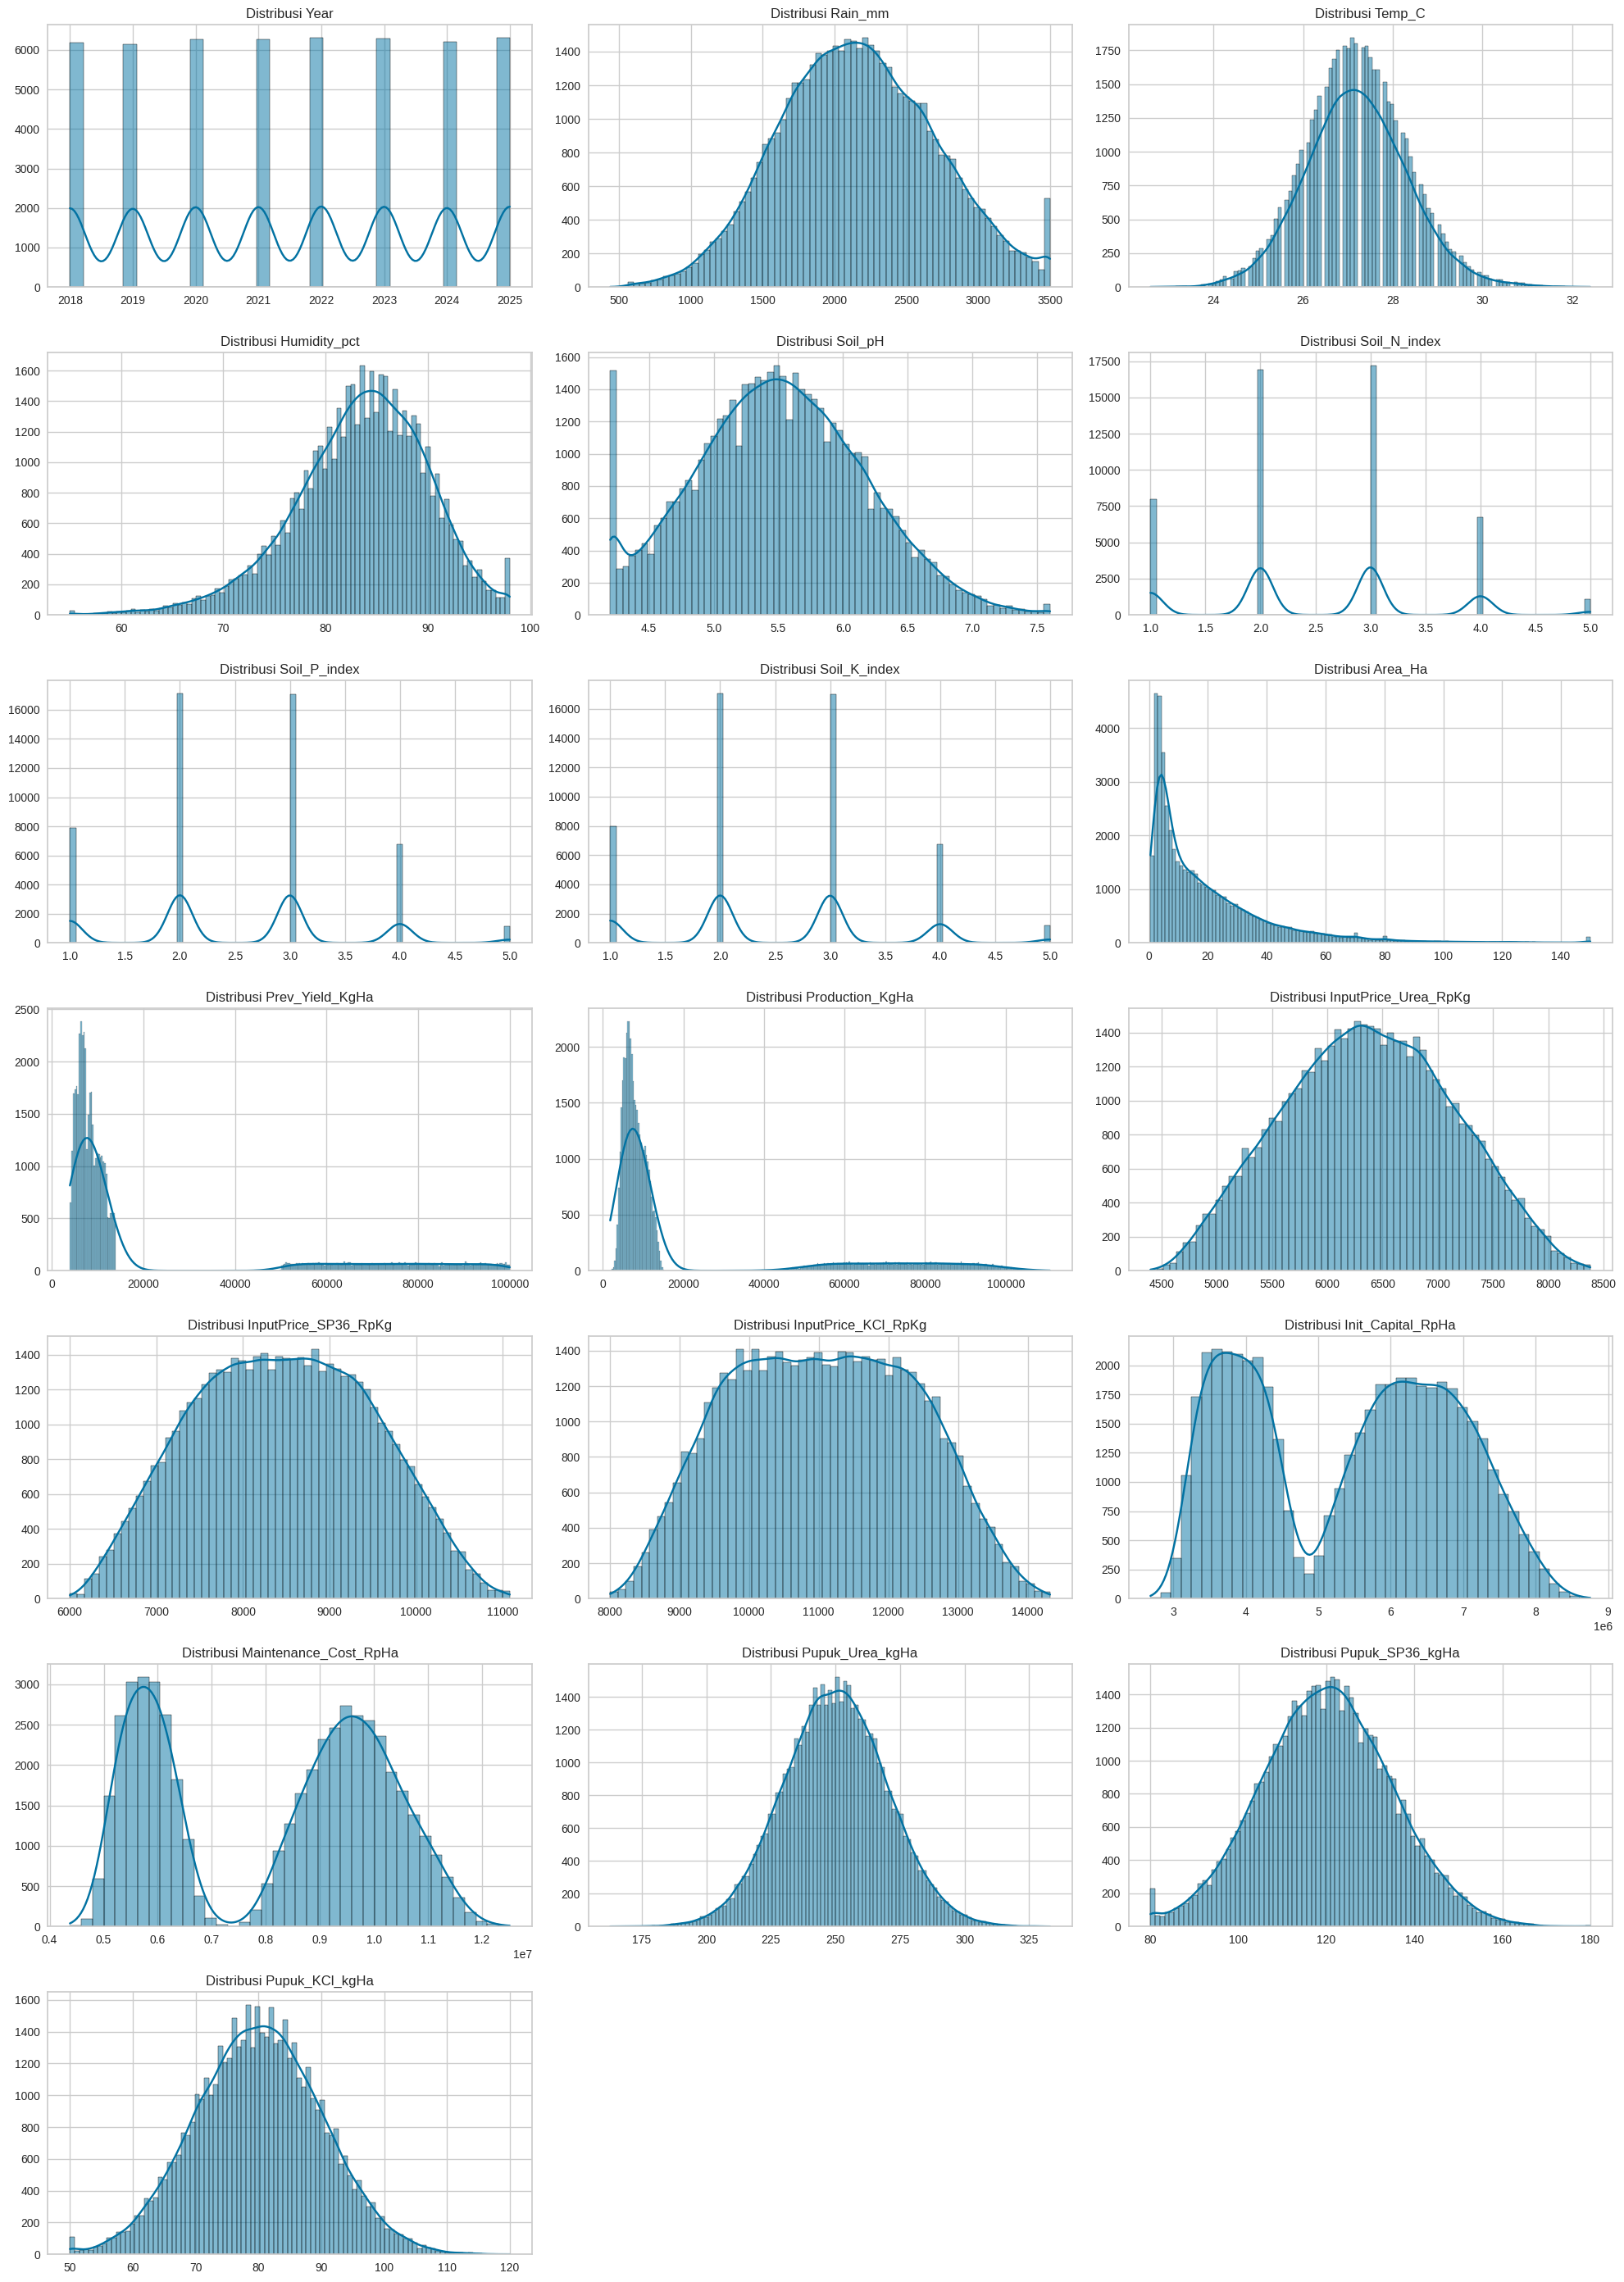

In [11]:
# Menghitung jumlah variabel
numeric_cols = df_clean.select_dtypes(include=['float64','int64']).columns

# Menentukan jumlah baris dan kolom untuk grid subplot
num_vars = len(numeric_cols)
n_cols = 3  # Jumlah kolom yang diinginkan
n_rows =-(-num_vars // n_cols)

# Membuat subplot
plt.figure(figsize=(20, n_rows * 4))


# Plot setiap variabel
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_clean[col], kde=True)
    plt.title(f"Distribusi {col}")
    plt.xlabel("")
    plt.ylabel("")

# Menyesuaikan layout agar lebih rapi
plt.tight_layout()
plt.show()


# Penjelasan bebrapa grafik distribusi di atas

**1. Distribusi Maintenance_Cost_RpHa**

Distribusi biaya perawatan per hektar (Maintenance_Cost_RpHa) menunjukkan pola bimodal, yaitu terdapat dua puncak distribusi yang jelas.
Hal ini mengindikasikan bahwa terdapat dua kelompok atau klaster biaya perawatan yang berbeda di dalam data — kemungkinan besar disebabkan oleh:

Perbedaan komoditas yang memiliki kebutuhan perawatan berbeda (misalnya, tanaman pangan vs hortikultura).

Perbedaan wilayah atau teknologi budidaya (misalnya, mekanisasi di daerah maju vs tradisional di daerah lain).

Dari sisi statistik, distribusi bimodal ini menandakan bahwa data tidak mengikuti distribusi normal tunggal, sehingga transformasi atau pendekatan model non-linear (misal Random Forest, XGBoost) lebih sesuai daripada regresi linier sederhana.

**2. Distribusi Production_KgHa**

Distribusi hasil produksi per hektar (Production_KgHa) menunjukkan skewness (kemencengan) ke kanan yang ekstrem (positively skewed).
Artinya:

Sebagian besar lahan memiliki produksi rendah hingga sedang,

Namun terdapat beberapa lahan dengan produksi sangat tinggi yang menjadi outlier atau kasus khusus (misalnya karena varietas unggul, irigasi intensif, atau penggunaan pupuk tinggi).

Distribusi ini umum dalam data agribisnis karena produksi sangat dipengaruhi oleh faktor lingkungan, input, dan teknologi.
Untuk analisis model, kondisi ini biasanya diatasi dengan transformasi logaritmik (log-transform) agar mendekati distribusi normal.


**3. Distribusi Pupuk_Urea_kgHa**

Distribusi pemakaian pupuk urea per hektar (Pupuk_Urea_kgHa) menunjukkan bentuk menyerupai distribusi normal (bell-shaped curve) dengan sedikit skewness ke kanan.
Hal ini menandakan bahwa:

Sebagian besar petani menerapkan dosis urea dalam kisaran umum yang sama,

Variasi dosis di luar kisaran tersebut relatif kecil.

Distribusi ini baik karena menunjukkan pola penggunaan pupuk yang homogen, sehingga dapat diasumsikan stabil untuk membangun model rekomendasi pemupukan.
Jika digunakan untuk regresi, data ini cenderung tidak memerlukan transformasi tambahan.

**4. Distribusi Year**

Distribusi Year menunjukkan pola frekuensi yang seragam, dengan tinggi batang histogram relatif sama di setiap tahun.
Ini mengindikasikan bahwa:

Dataset memiliki jumlah observasi yang seimbang antar tahun,

Tidak ada bias temporal (misalnya, data tahun tertentu mendominasi).

Namun, pola gelombang pada kurva KDE (garis biru) terjadi karena jumlah tahun yang terbatas dan data diskrit — sehingga kernel density estimation (yang cocok untuk data kontinu) tidak mampu menggambarkan distribusi dengan sempurna.

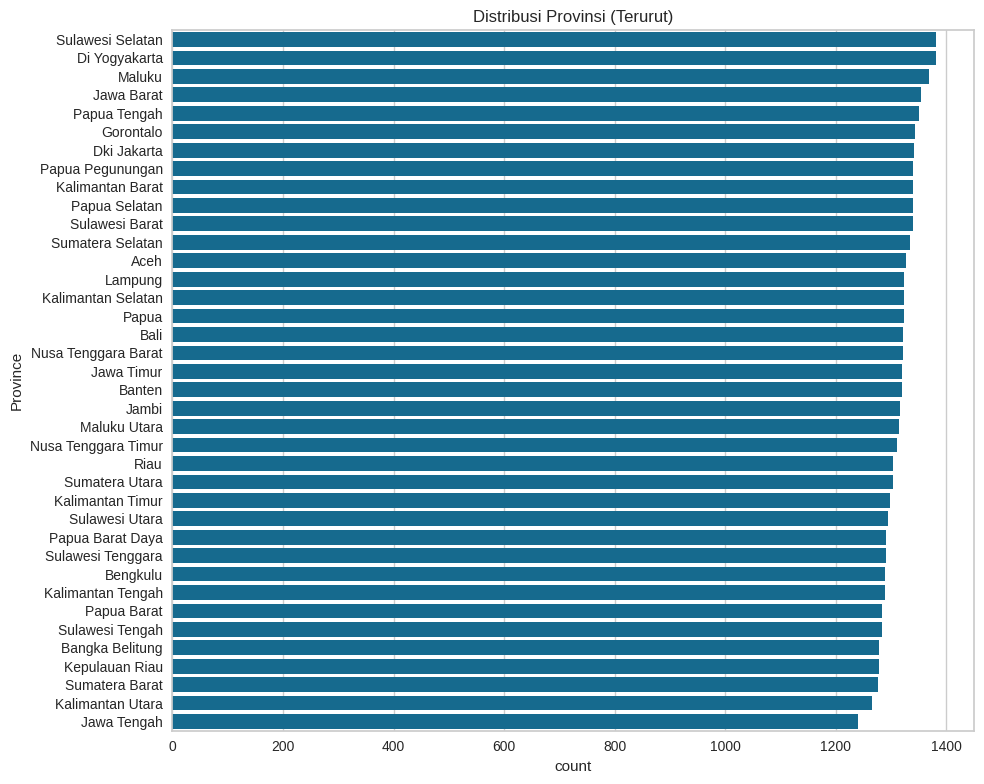

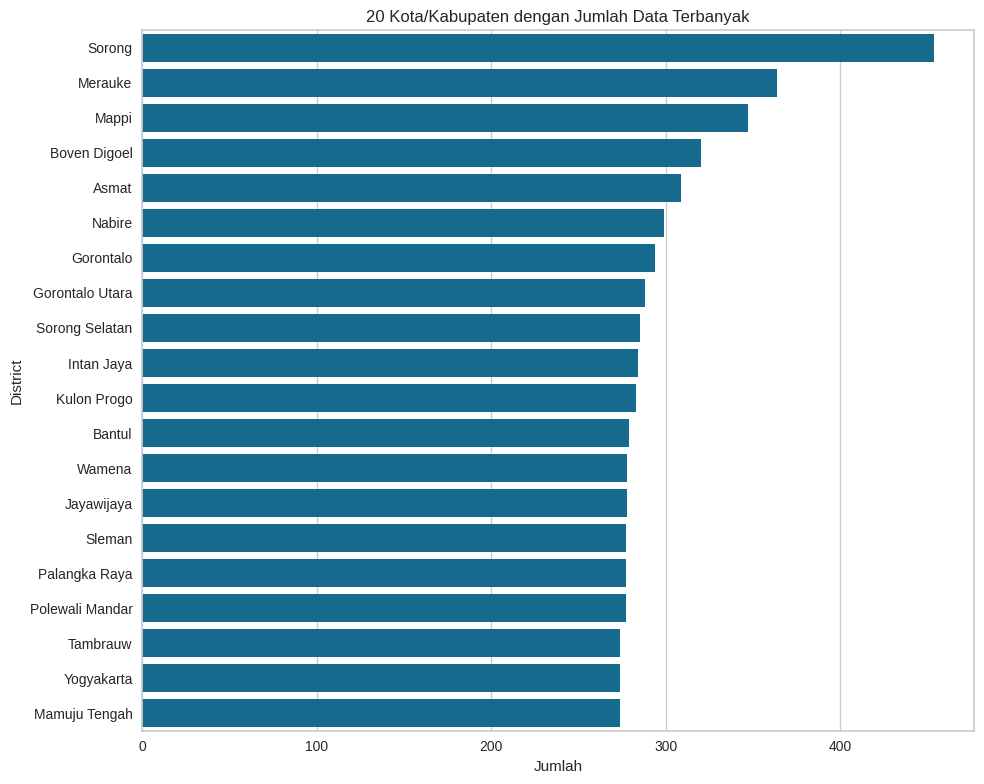

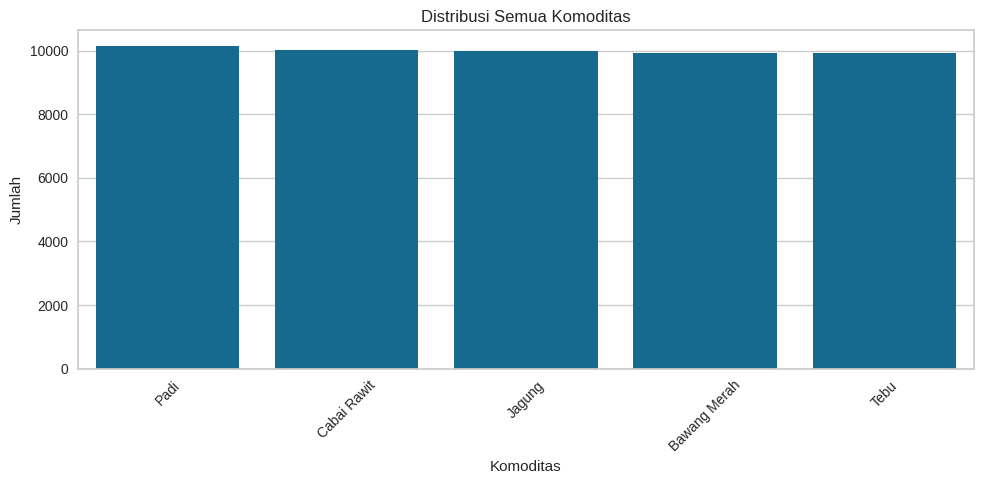

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengurutkan distribusi provinsi
plt.figure(figsize=(10,8))
sns.countplot(y="Province", data=df, order=df["Province"].value_counts().index)
plt.title("Distribusi Provinsi (Terurut)")
plt.tight_layout()
plt.show()

# Menampilkan 20 kota dengan jumlah data terbanyak
top_districts = df["District"].value_counts().head(20)

plt.figure(figsize=(10,8))
sns.barplot(x=top_districts.values, y=top_districts.index)
plt.title("20 Kota/Kabupaten dengan Jumlah Data Terbanyak")
plt.xlabel("Jumlah")
plt.ylabel("District")
plt.tight_layout()
plt.show()

# Menampilkan semua distribusi komoditas
plt.figure(figsize=(10,5))
sns.countplot(x="Commodity", data=df, order=df["Commodity"].value_counts().index)
plt.title("Distribusi Semua Komoditas")
plt.xlabel("Komoditas")
plt.ylabel("Jumlah")
plt.xticks(rotation=45)  # miringkan label agar tidak tumpang tindih
plt.tight_layout()
plt.show()


# Analisis Distribusi

**Distribusi Provinsi (Terurut**)

Grafik ini menampilkan jumlah data per provinsi di Indonesia secara terurut dari yang terbanyak ke yang paling sedikit.
Terlihat bahwa distribusi data relatif merata antar provinsi, dengan provinsi seperti Sulawesi Selatan, D.I. Yogyakarta, Maluku, dan Jawa Barat memiliki jumlah observasi sedikit lebih tinggi dibandingkan provinsi lain.


Sebaran data yang relatif seimbang antar provinsi menunjukkan representasi spasial yang baik. Ini penting untuk menghindari bias geografis pada model prediksi atau rekomendasi.

Namun, sedikit dominasi pada beberapa provinsi bisa menunjukkan bahwa aktivitas pertanian yang terdokumentasi lebih banyak di wilayah-wilayah dengan intensitas pertanian tinggi (misal Sulawesi Selatan dan Jawa Barat).

Dalam konteks penelitian agribisnis, hal ini bisa mencerminkan variasi data produksi dan input pertanian antar daerah, yang perlu diakomodasi dengan pendekatan analisis berbasis wilayah (misal fixed effect per provinsi).

 **Distribusi 20 Kota/Kabupaten dengan Data Terbanyak**

Grafik ini menampilkan 20 kabupaten/kota dengan jumlah data terbanyak.
Kabupaten/kota seperti Sorong, Merauke, Mappi, Boven Digoel, dan Asmat mendominasi jumlah data terbanyak, diikuti oleh Nabire, Gorontalo, dan Kulon Progo.

Sebagian besar kabupaten dengan data terbanyak berasal dari kawasan Indonesia Timur, khususnya Papua dan Gorontalo. Hal ini mengindikasikan bahwa proyek pengumpulan data atau survei pertanian mungkin lebih intensif di wilayah-wilayah tersebut.

Kabupaten seperti Bantul, Sleman, dan Kulon Progo (DIY) juga muncul di daftar ini, mencerminkan adanya kegiatan budidaya yang terdokumentasi dengan baik di wilayah pertanian produktif Jawa.

Persebaran seperti ini penting untuk mempertimbangkan pembobotan spasial (spatial weighting) dalam model agar tidak terlalu dipengaruhi oleh daerah dengan jumlah data besar.

**Distribusi Semua Komoditas**

Grafik ini memperlihatkan distribusi jumlah data pada lima komoditas utama:

1. Padi

2. Cabai rawit

3. Jagung

4. Bawang merah

5. Tebu


Distribusi kelima komoditas tersebut terlihat seimbang, masing-masing sekitar 10.000 observasi.
Hal ini menunjukkan bahwa dataset memiliki representasi yang setara antar komoditas, sehingga:

Model tidak akan bias terhadap satu komoditas tertentu.

Analisis komparatif antar komoditas (misalnya efisiensi input, biaya perawatan, atau hasil produksi) dapat dilakukan secara adil.

Kesetaraan distribusi ini memperkuat validitas dataset untuk analisis multi-komoditas, seperti pengembangan model rekomendasi pupuk lintas komoditas atau analisis kinerja rantai pasok pertanian.

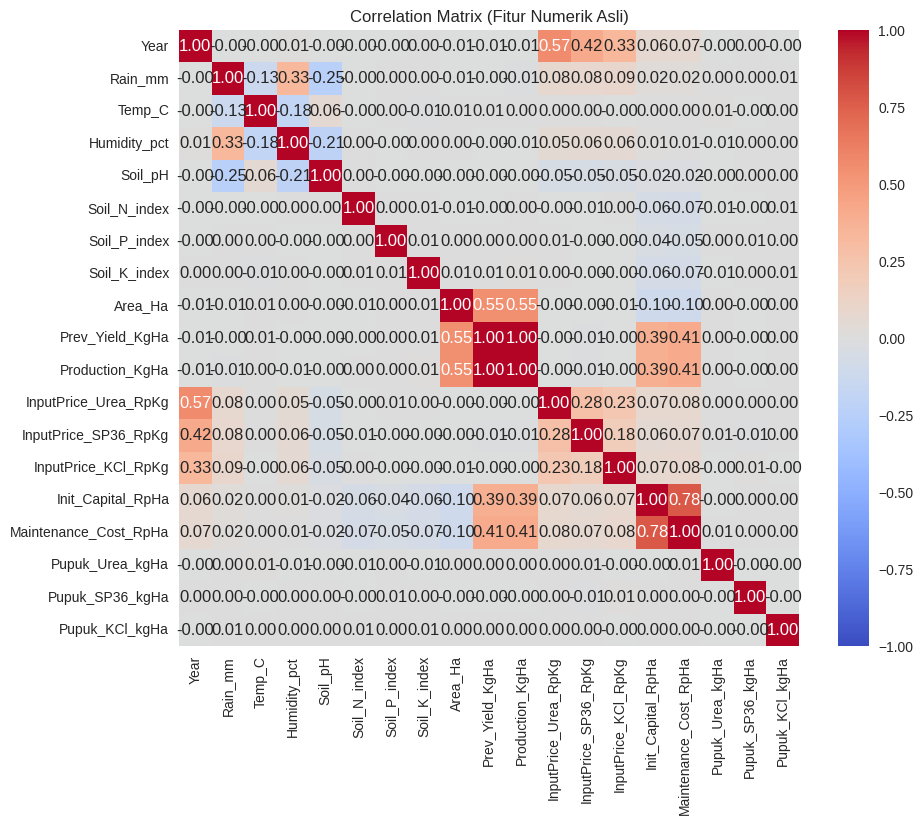

In [13]:
# Visualisasi korelasi antar variabel numerik
numeric_cols = df_clean.select_dtypes(include=['float64','int64']).columns
correlation_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix (Fitur Numerik Asli)')
plt.show()



# Analisis Korelasi Numerik Dataset Pertanian

**Gambaran Umum**

Gambar korelasi di atas menunjukkan hubungan antar variabel numerik dalam dataset (seperti iklim, tanah, harga input, biaya, dan hasil pertanian).
Nilai korelasi berkisar antara –1 hingga +1:

Nilai mendekati +1 → hubungan positif kuat (jika satu naik, yang lain ikut naik).

Nilai mendekati –1 → hubungan negatif kuat (jika satu naik, yang lain turun).

Nilai mendekati 0 → hubungan sangat lemah atau tidak ada korelasi.

Secara umum, dataset ini didominasi korelasi lemah hingga sedang, menandakan bahwa variabel-variabel memiliki pengaruh parsial dan tidak saling mendominasi, yang baik untuk keperluan model prediktif multivariat (seperti regresi atau machine learning).

**Korelasi paling besar**

| Hubungan Variabel                             | Nilai Korelasi | Interpretasi                                                                                                                                                              |
| --------------------------------------------- | -------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `Prev_Yield_KgHa` dan `Production_KgHa`         | **0.55**       | Korelasi positif sedang; hasil panen sebelumnya berpengaruh terhadap hasil panen saat ini. Hal ini wajar karena faktor lahan dan manajemen budidaya seringkali konsisten antar musim. |
| `Area_Ha` dan `Prev_Yield_KgHa`                 | **0.55**       | Lahan yang lebih luas cenderung memiliki produktivitas historis yang lebih besar; bisa juga menunjukkan efek skala usaha (economies of scale).                                        |
| `Area_Ha` dan `Production_KgHa`                 | **0.55**       | Korelasi positif sedang antara luas lahan dan total produksi menunjukkan kontribusi area terhadap total hasil.                                                                        |
| `Init_Capital_RpHa` dan `Maintenance_Cost_RpHa` | **0.78**       | Hubungan kuat; semakin besar modal awal, semakin besar pula biaya perawatan. Ini menandakan keterkaitan antara investasi dan intensitas pengelolaan lahan.                            |
| `InputPrice_Urea_RpKg` dan `Year`               | **0.57**       | Korelasi positif menunjukkan adanya **kenaikan harga input pupuk urea seiring waktu (inflasi atau kebijakan subsidi)**.                                                               |
| `InputPrice_SP36_RpKg` dan `Year`               | **0.42**       | Kenaikan harga SP-36 juga mengikuti tren waktu, walau tidak sekuat urea.                                                                                                              |
| `InputPrice_KCl_RpKg` dan `Year`                | **0.33**       | Kenaikan harga KCl relatif moderat dibanding dua pupuk lain, mungkin karena variasi impor dan pasokan pasar global.                                                                   |


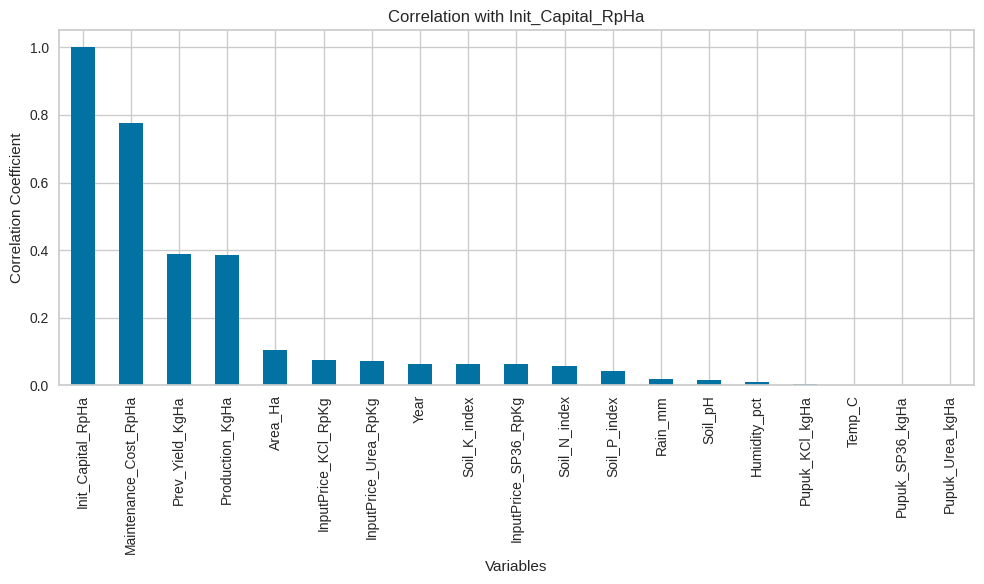

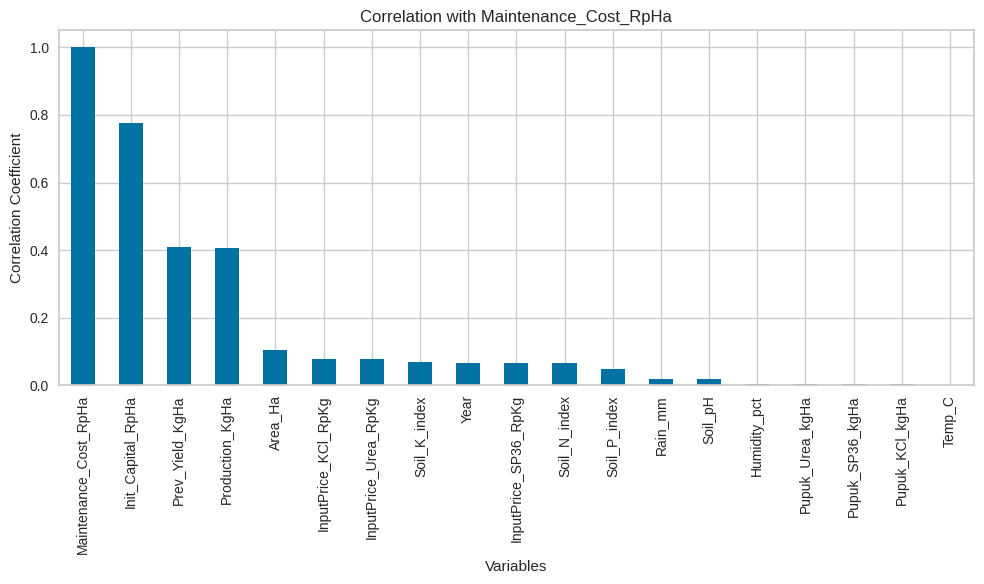

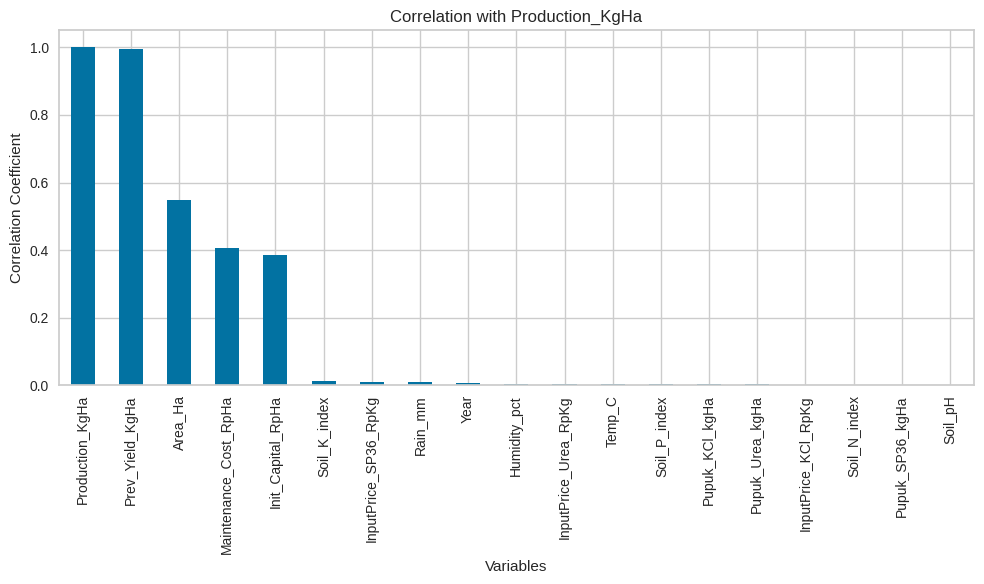

In [14]:
# Menghitung korelasi antara variabel target dan semua variabel lainnya
# Hanya mengambil kolom numerik
numeric_df = df_clean.select_dtypes(include=['float64','int64'])

target_cols = ["Init_Capital_RpHa", "Maintenance_Cost_RpHa", "Production_KgHa"]

for target in target_cols:
    target_corr = numeric_df.corr()[target]  # hitung korelasi terhadap target
    target_corr_sorted = target_corr.abs().sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    target_corr_sorted.plot(kind='bar')
    plt.title(f'Correlation with {target}')
    plt.xlabel('Variables')
    plt.ylabel('Correlation Coefficient')
    plt.tight_layout()
    plt.show()


# Korelasi target dengan variabel lainnya

**Korelasi terhadap Init_Capital_RpHa**

Modal awal (Init_Capital_RpHa) berfungsi sebagai komponen investasi utama dalam sistem produksi pertanian. Nilai korelasi menunjukkan bahwa sebagian besar modal dialokasikan untuk komponen biaya perawatan (pupuk, tenaga kerja, pengendalian hama, dan pemeliharaan lahan).
Hubungan positif dengan hasil (Production_KgHa) memperlihatkan bahwa tingkat investasi memiliki efek nyata terhadap produktivitas, sebagaimana dikemukakan oleh Hayami dan Ruttan (1987) bahwa intensifikasi modal mendorong efisiensi produksi dalam sistem pertanian modern.

**Korelasi terhadao Maintenance_Cost_RpHa**


Biaya perawatan (Maintenance_Cost_RpHa) berperan sebagai indikator intensitas pengelolaan lahan. Korelasi yang kuat dengan modal awal menandakan keterpaduan antara keputusan investasi dan strategi pemeliharaan.
Hasil ini sejalan dengan pandangan Ellis (1993) bahwa petani dengan kapasitas modal lebih besar cenderung mengalokasikan sumber daya lebih optimal untuk pemeliharaan guna meminimalkan risiko gagal panen.

**Korelasi terhadap Production_KgHa**

Produksi pertanian (Production_KgHa) memiliki hubungan erat dengan produktivitas masa lalu dan biaya input, memperlihatkan pola kesinambungan (path dependency) dalam sistem pertanian.
Hal ini konsisten dengan teori production function Cobb–Douglas, di mana output ditentukan oleh kombinasi faktor modal, tenaga kerja, dan teknologi (Douglas, 1948). Dalam konteks ini, Prev_Yield_KgHa merefleksikan faktor teknologi dan kemampuan lahan, sedangkan Maintenance_Cost_RpHa merepresentasikan intensitas input modal.



| Target Variabel           | Faktor Paling Berpengaruh                               | Implikasi                                                               |
| ------------------------- | ------------------------------------------------------- | ----------------------------------------------------------------------- |
| **Init_Capital_RpHa**     | Maintenance_Cost_RpHa, Production_KgHa, Prev_Yield_KgHa | Modal awal tinggi meningkatkan kapasitas input dan produktivitas        |
| **Maintenance_Cost_RpHa** | Init_Capital_RpHa, Production_KgHa, Prev_Yield_KgHa     | Biaya perawatan mencerminkan intensitas pengelolaan dan efisiensi modal |
| **Production_KgHa**       | Prev_Yield_KgHa, Area_Ha, Maintenance_Cost_RpHa         | Produksi dipengaruhi oleh hasil sebelumnya dan skala usaha              |


# Feature Engineering

In [15]:
# Fitur Interaksi Iklim
df_clean['Temp_Humid_Interaction'] = df_clean['Temp_C'] * df_clean['Humidity_pct']

# Fitur Indeks Kesuburan Tanah
df_clean['Soil_Fertility_Index'] = (
    df_clean['Soil_N_index'] +
    df_clean['Soil_P_index'] +
    df_clean['Soil_K_index']
) / 3

#  Fitur Polinomial (Aman)
df_clean['Soil_pH_sq'] = df_clean['Soil_pH']**2

# Fitur Ekonomi (Aman)
df_clean['Avg_Fertilizer_Price'] = (
    df_clean['InputPrice_Urea_RpKg'] +
    df_clean['InputPrice_SP36_RpKg'] +
    df_clean['InputPrice_KCl_RpKg']
) / 3

print(f"Fitur-fitur baru berhasil dibuat: {['Temp_Humid_Interaction', 'Soil_Fertility_Index', 'Soil_pH_sq', 'Avg_Fertilizer_Price']}")

Fitur-fitur baru berhasil dibuat: ['Temp_Humid_Interaction', 'Soil_Fertility_Index', 'Soil_pH_sq', 'Avg_Fertilizer_Price']


# Data Splitting

In [16]:
# mendefinisikan Target
prediction_targets = ["Production_KgHa", "Init_Capital_RpHa", "Maintenance_Cost_RpHa"]

# mendefinisikan SEMUA kolom yang harus dibuang
columns_to_drop = [
    # Kolom Target Prediksi
    "Production_KgHa", "Init_Capital_RpHa", "Maintenance_Cost_RpHa",

    # Kolom Target Rekomendasi
    "Pupuk_Urea_kgHa", "Pupuk_SP36_kgHa", "Pupuk_KCl_kgHa",

    # Kolom Bocor (Leaked Features) dari error Anda sebelumnya
    "Prev_Yield_KgHa", "Year_Offset", "Production_Trend", "Yield_per_Area",
    "Rain_mm_log", "Cost_per_Kg",

    # Kolom turunan lain yang mungkin ada
    "Soil_pH_Category", "Rain_Category"
]

# membuat X dan y dari df_clean (DATA MENTAH + FITUR AMAN)
X = df_clean.drop(columns=[col for col in columns_to_drop if col in df_clean.columns])
y = df_clean[prediction_targets]

print("\nFitur-fitur final yang digunakan untuk melatih model:")
print(X.columns.tolist())

#  melakukan Data Splitting pada DATA MENTAH
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Fitur-fitur final yang digunakan untuk melatih model:
['Province', 'District', 'Year', 'Commodity', 'Rain_mm', 'Temp_C', 'Humidity_pct', 'Soil_pH', 'Soil_N_index', 'Soil_P_index', 'Soil_K_index', 'Area_Ha', 'InputPrice_Urea_RpKg', 'InputPrice_SP36_RpKg', 'InputPrice_KCl_RpKg', 'Temp_Humid_Interaction', 'Soil_Fertility_Index', 'Soil_pH_sq', 'Avg_Fertilizer_Price']


In [17]:
print("Ukuran dataset:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Ukuran dataset:
X_train: (39995, 19)
X_test: (9999, 19)
y_train: (39995, 3)
y_test: (9999, 3)


# Model Regresi

In [18]:

# Mengidentifikasi kolom numerik dan kategorikal dari data training
numeric_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# Membuat ColumnTransformer untuk menerapkan transformasi yang berbeda
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)
print(f"Pipeline preprocessor berhasil dibuat.")

# PERBANDINGAN MODEL SECARA SISTEMATIS
# Kamus model yang akan diuji
models_to_test = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1) # verbose=-1 untuk output bersih
}

# Dictionary untuk menyimpan model terbaik untuk setiap target
best_models = {}

# Loop untuk setiap target prediksi
for target_col in target_cols:
    print("-" * 50)
    print(f"Memproses Target: {target_col}")
    results = []

    # Loop untuk setiap model dalam kamus
    for name, model in models_to_test.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])


        #  Ambil target yang sesuai dari y_train
        y_train_target = y_train[target_col]

        # melatih pipeline dengan data training
        pipeline.fit(X_train, y_train_target)


        # Setelah dilatih, baru lakukan prediksi
        y_pred = pipeline.predict(X_test)

        # Evaluasi terhadap y_test yang sesuai
        r2 = r2_score(y_test[target_col], y_pred)
        rmse = np.sqrt(mean_squared_error(y_test[target_col], y_pred))

        results.append({
            "Model": name,
            "R2_Score": r2,
            "RMSE": rmse,
        })

    # Tampilkan tabel perbandingan
    comparison_df = pd.DataFrame(results).sort_values(by="R2_Score", ascending=False).reset_index(drop=True)
    print("Tabel Perbandingan Model:")
    print(comparison_df.to_string())

    # MEMILIH DAN MENYIMPAN MODEL TERBAIK (Kode ini sudah benar)
    best_model_name = comparison_df.loc[0, "Model"]
    best_model_obj = models_to_test[best_model_name]

    print(f"\nModel terbaik untuk '{target_col}' adalah: {best_model_name}")





Pipeline preprocessor berhasil dibuat.
--------------------------------------------------
Memproses Target: Init_Capital_RpHa


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Tabel Perbandingan Model:
               Model  R2_Score           RMSE
0           LightGBM  0.842156  571415.165942
1              Ridge  0.841592  572433.958711
2  Linear Regression  0.841581  572454.276988
3      Random Forest  0.837708  579409.179681
4            XGBoost  0.834419  585251.442496

Model terbaik untuk 'Init_Capital_RpHa' adalah: LightGBM
--------------------------------------------------
Memproses Target: Maintenance_Cost_RpHa


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Tabel Perbandingan Model:
               Model  R2_Score           RMSE
0           LightGBM  0.921845  571851.081354
1              Ridge  0.920496  576763.595482
2  Linear Regression  0.920488  576792.638082
3      Random Forest  0.918879  582599.819960
4            XGBoost  0.917782  586524.688954

Model terbaik untuk 'Maintenance_Cost_RpHa' adalah: LightGBM
--------------------------------------------------
Memproses Target: Production_KgHa
Tabel Perbandingan Model:
               Model  R2_Score         RMSE
0              Ridge  0.932569  7027.137157
1  Linear Regression  0.932562  7027.473442
2           LightGBM  0.930597  7129.144297
3      Random Forest  0.930464  7135.984652
4            XGBoost  0.926415  7340.787739

Model terbaik untuk 'Production_KgHa' adalah: Ridge


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [19]:
# mendefinisikan Target
prediction_targets = ["Production_KgHa", "Init_Capital_RpHa", "Maintenance_Cost_RpHa"]

# KOREKSI UTAMA: Buat daftar kolom yang harus dibuang dari fitur

columns_to_drop = [
    "Production_KgHa", "Init_Capital_RpHa", "Maintenance_Cost_RpHa",
    "Pupuk_Urea_kgHa", "Pupuk_SP36_kgHa", "Pupuk_KCl_kgHa",
    "Prev_Yield_KgHa" # Tambahkan kolom leakage lain jika ada
]

# membuat X dengan membuang semua kolom yang tidak relevan
X = df_clean.drop(columns=[col for col in columns_to_drop if col in df_clean.columns])
y_all = df_clean[prediction_targets]

# melakukan train-test split yang sudah bersih
X_train, X_test, y_train_all, y_test_all = train_test_split(X, y_all, test_size=0.2, random_state=42)

print(f"Jumlah fitur yang digunakan untuk training: {X_train.shape[1]}")

# mendefinisikan Preprocessor
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])
print("Preprocessor berhasil dibuat.")

# Loop untuk Melatih dan Menyimpan Setiap Model
for target_col in prediction_targets:
    print(f"Memulai pelatihan untuk target: {target_col}...")

    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    ])

    y_train_target = y_train_all[target_col]
    final_pipeline.fit(X_train, y_train_target)
    print(f"Pelatihan untuk '{target_col}' selesai.")

    # Simpan pipeline yang sudah dilatih ke file baru
    file_name = f'pipeline_{target_col}_final.pkl'
    joblib.dump(final_pipeline, file_name)
    print(f"Pipeline baru berhasil disimpan sebagai: '{file_name}'")


print("Semua model prediksi telah berhasil dilatih ulang dan disimpan!")

Jumlah fitur yang digunakan untuk training: 19
Preprocessor berhasil dibuat.
Memulai pelatihan untuk target: Production_KgHa...
Pelatihan untuk 'Production_KgHa' selesai.
Pipeline baru berhasil disimpan sebagai: 'pipeline_Production_KgHa_final.pkl'
Memulai pelatihan untuk target: Init_Capital_RpHa...
Pelatihan untuk 'Init_Capital_RpHa' selesai.
Pipeline baru berhasil disimpan sebagai: 'pipeline_Init_Capital_RpHa_final.pkl'
Memulai pelatihan untuk target: Maintenance_Cost_RpHa...
Pelatihan untuk 'Maintenance_Cost_RpHa' selesai.
Pipeline baru berhasil disimpan sebagai: 'pipeline_Maintenance_Cost_RpHa_final.pkl'
Semua model prediksi telah berhasil dilatih ulang dan disimpan!


# Model Klasifikasi

In [20]:
#Mendefinisikan Model Rekomendeasi


class SimilarityRecommender:

    def __init__(self):
        self.dataset = None
        self.is_fitted = False

    def fit(self, df):

        # Menyimpan salinan data yang bersih dan relevan
        required_cols = [
            'Commodity', 'Province', 'Soil_pH', 'Temp_C',
            'Pupuk_Urea_kgHa', 'Pupuk_SP36_kgHa', 'Pupuk_KCl_kgHa'
        ]

        # Pastikan semua kolom yang dibutuhkan ada
        if not all(col in df.columns for col in required_cols):
            raise ValueError(f"DataFrame harus memiliki kolom: {', '.join(required_cols)}")

        self.dataset = df[required_cols].copy()
        self.is_fitted = True
        print("Model SimilarityRecommender berhasil 'dilatih' (mengingat data historis).")
        return self

    def recommend(self, commodity, province, soil_ph, temp_c):

        if not self.is_fitted:
            raise RuntimeError("Model harus di-'fit' terlebih dahulu dengan data sebelum memberikan rekomendasi.")

        # 1. Filter data berdasarkan input kategori yang sama persis
        filter_awal = self.dataset[
            (self.dataset['Commodity'] == commodity) &
            (self.dataset['Province'] == province)
        ]

        if filter_awal.empty:
            return {"status": "error", "message": f"Tidak ada data historis untuk '{commodity}' di provinsi '{province}'."}

        # Filter lebih lanjut berdasarkan rentang kemiripan numerik
        ph_min, ph_max = soil_ph - 0.5, soil_ph + 0.5
        temp_min, temp_max = temp_c - 2, temp_c + 2

        filter_lanjutan = filter_awal[
            (filter_awal['Soil_pH'].between(ph_min, ph_max)) &
            (filter_awal['Temp_C'].between(temp_min, temp_max))
        ]

        # menentukan dataset mana yang akan digunakan
        final_df = filter_lanjutan if not filter_lanjutan.empty else filter_awal
        source_data = "data yang sangat mirip" if not filter_lanjutan.empty else "data provinsi secara umum"

        # Menghitung dosis pupuk (median lebih aman dari outlier)
        rekomendasi = {
            'urea_kg_ha': final_df['Pupuk_Urea_kgHa'].median(),
            'sp36_kg_ha': final_df['Pupuk_SP36_kgHa'].median(),
            'kcl_kg_ha': final_df['Pupuk_KCl_kgHa'].median()
        }

        return {
            "status": "success",
            "rekomendasi": rekomendasi,
            "sumber_data": f"Berdasarkan {len(final_df)} petani dengan {source_data}."
        }

# Inisialisasi model
model_rekomendasi_benar = SimilarityRecommender()

# Latih model dengan data bersih Anda
model_rekomendasi_benar.fit(df_clean)

# Simpan dengan NAMA FILE YANG BENAR
# Ini akan menimpa file lama Anda yang salah
nama_file_rekom = 'model_rekomendasi_pupuk.pkl'
joblib.dump(model_rekomendasi_benar, nama_file_rekom)

print(f"Model SimilarityRecommender BERHASIL disimpan sebagai: '{nama_file_rekom}'")

Model SimilarityRecommender berhasil 'dilatih' (mengingat data historis).
Model SimilarityRecommender BERHASIL disimpan sebagai: 'model_rekomendasi_pupuk.pkl'
